In [1]:
from importlib import reload  
import numpy as np
import matplotlib.pyplot as plt
import pycraf
import cysgp4
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry
from astropy import units as u, constants as const
from scepter import skynet,obs
from astropy import coordinates as coord



In [2]:
###reload here
reload(skynet)
reload(obs)

#### OTT1
#  geographic longitude: 	 11° 55′ 11″
#  geographic latitude: 	 57° 23′ 37″
#  altitude above sea level: 	 16 m
#  diameter of telescope: 	 13.2 m
#  minimum elevation: 	  0°

#### OTT2
#  geographic longitude: 	 11° 55′ 08″
#  geographic latitude: 	 57° 23′ 35″
#  altitude above sea level: 	 16 m
#  diameter of telescope: 	 13.2 m
#  minimum elevation: 	  0°

### we're testing with the ie613 lofar station location
longitude = coord.Angle("11d55m11s").deg
latitude = coord.Angle("+57d23m37s").deg
elevation = 16 * u.m

observatory1=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)
longitude = coord.Angle("11d55m08s").deg
latitude = coord.Angle("+57d23m35s").deg
elevation = 16 * u.m
observatory2=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)

In [3]:
obsmode='continuum'
ras_df = protection.ra769_limits(mode=obsmode).to_pandas() # 150 MHz RAS band
ras_tab = protection.ra769_limits(mode='continuum')[12] # 1.4 GHz RAS band
# print(ras_df)
print(ras_tab)
# Rx (RAS) parameters
eta_a_rx = 100 * u.percent

frequency bandwidth T_A T_rx T_rms  P_rms_nu   Plim   Plim_nu      Slim        Slim_nu        Efield    Efield_norm 
   MHz       MHz     K   K     mK  dB(W / Hz) dB(W)  dB(W / Hz) dB(W / m2) dB(W / (Hz m2)) dB(uV2 / m2) dB(uV2 / m2)
--------- --------- --- ---- ----- ---------- ------ ---------- ---------- --------------- ------------ ------------
    15375        50  15   15 0.095     -268.8 -201.8     -278.8     -156.6          -233.6        -10.9        -27.9


In [4]:
min_elevation = -30 * u.deg
grid_size = 3. * u.deg
npoints=1 ##pointing per cell
skygrid = skynet.pointgen(niters=npoints,
    step_size=grid_size,
    lat_range=(min_elevation, 90 * u.deg),
    rnd_seed=0,
    )

tel_az, tel_el, grid_info = skygrid 
# print('-' * 80)
# print('Minimum elevation: {0:.2f}'.format(min_elevation))
# print('Number of cells: {0:d}'.format(len(grid_info)))
# print('-' * 80)
# ncell=len(grid_info)
print(tel_az.shape)
## match dimensions of this simulation
# tel_az=tel_az[:,np.newaxis,np.newaxis,np.newaxis]
# tel_el=tel_el[:,np.newaxis,np.newaxis,np.newaxis]

freq = ras_tab['frequency']

p_lim = ras_tab['Plim']
pfd_lim = ras_tab['Slim']
ras_bandwidth = ras_tab['bandwidth']
margin = 0

p_tx_carrier = (-44+margin) * cnv.dBm #CISPR22 maximum emission at 150 MHz is -44 dBm
carrier_bandwidth = ras_tab['bandwidth'] #this is not specified in the french section...
duty_cycle = 100 * u.percent
print(ras_bandwidth)




(1, 3438)
50.0 MHz


In [5]:
### set up transmitter class
tx=obs.transmitter_info(p_tx_carrier, carrier_bandwidth, duty_cycle, d_tx=1*u.m,freq=freq)
p_tx=tx.power_tx(ras_bandwidth)
print(p_tx)

-44.0 dB(mW)


In [6]:
dish=13.2*u.m
eta=0.7 *100*u.percent ## in percentage
### frequency band
## transmitter parameters
sat_antenna=0.1*u.m
### observatory list will be passed on internally like this
observers = np.array([observatory1,observatory2])
rx=obs.receiver_info(dish,eta,observers,freq,bandwidth=ras_bandwidth)

In [7]:
rx.location.T.shape


(2,)

1.2589254117941673 W / (Hz m2)


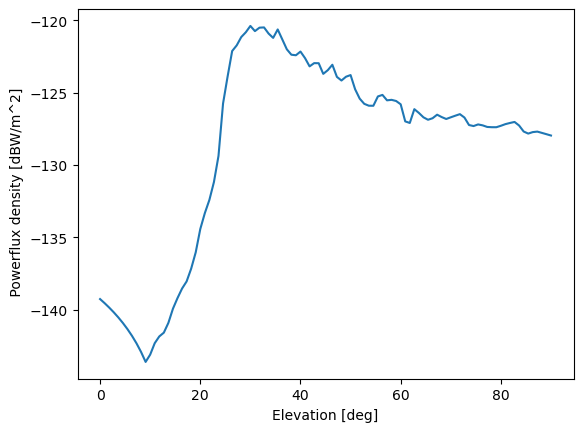

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
el_response=pd.read_csv('starlink_statistical_pfd.csv')
x_el=el_response['el'].values
y_spfd=el_response['psd_dBW_m2_4khz'].values  ### spectral powerflux density

scale4khz=50e6/4e3 ###4kHz to 1 Hz 
print((1*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz))
###powerflux_nu = powerflux / bandwidth

y_pfd=(y_spfd*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz)*(scale4khz*u.Hz) ### powerflux density I think in dB units it's this log factor, maybe should change this methiod
y_pfd=y_pfd.to(cnv.dB_W_m2)
plt.plot(x_el,y_pfd)
plt.ylabel(' Powerflux density [dBW/m^2]')
plt.xlabel('Elevation [deg]')
plt.show()

In [9]:
satpwrpfd=np.interp(tel_el,xp=x_el,fp=y_pfd)  ### use this to replace transmitter side pfd
print(satpwrpfd[0])

[-139.27665307 -139.27665307 -139.27665307 ... -127.71642721 -127.70810597
 -127.86889694] dB(W / m2)


In [10]:
###load some tle from starlink
import requests
url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
ctrak_starlink = requests.get(url).text

tle_list = cysgp4.tle_tuples_from_text(ctrak_starlink)

# tle_list

In [11]:
### set time and simulation settings

niters = 2
pydt = cysgp4.PyDateTime() ## take current date and time
start_times_window = 24 * u.hour
time_range, time_resol = 100*u.s, 1*u.s  # seconds
epochiters=time_range/time_resol

# print(start_times,td)
mjds = skynet.plantime(niters,start_times_window,time_range,time_resol,pydt)
print(mjds.shape)

(1, 1, 1, 2, 100, 1)


In [12]:
tles = np.array([
    cysgp4.PyTle(*tle) for tle in tle_list
    ])[:500]  # use which TLEs

print (f'we are simulating {tles.shape[0]} satellites over {niters*start_times_window.to_value(u.day)} days,')
print(f'each day/epoch contains {epochiters} integrations over {time_range} seconds')
print(tles.shape)

we are simulating 500 satellites over 2.0 days,
each day/epoch contains 100.0 integrations over 100.0 s seconds
(500,)


In [13]:
test=obs.obs_sim(tx,rx,tles,skygrid,mjds)
print(rx.location)
print(test.tel_az.shape)

[<PyObserver: 11.9197d, 57.3936d, 0.0160km>
 <PyObserver: 11.9189d, 57.3931d, 0.0160km>]
(1, 1, 3438, 1, 1, 1)


In [14]:
test.populate()


(2, 1, 1, 1, 1, 1) (1, 1, 1, 1, 1, 500) (1, 1, 1, 2, 100, 1)
Obtaining satellite and time information, propagation for large arrays may take a while...
Done. Satellite coordinates obtained


In [15]:
### interpolate powerflux on the ground
star_el=test.topo_pos_el
satpwrpfd=(np.interp(star_el,xp=x_el,fp=y_pfd))  ###



In [16]:
g_rx=rx.antgain1d(test.tel_az,test.tel_el,test.topo_pos_az,test.topo_pos_el)

Obtaining satellite and telescope pointing coordinates, calculation for large arrays may take a while...
Done. putting angular separation into gain pattern function


In [17]:
prx=cnv.prx_from_powerflux (satpwrpfd,freq=ras_bandwidth,grx=g_rx)


### test with angled beams
# ang_sep=test.txbeam_angsep(beam_az=20,beam_el=0)
# gtx=tx.satgain1d(ang_sep) 
# sat_power=tx.fspl(test.obs_dist*u.km,gtx)
# print (sat_power.shape)

# prx=obs.prx_cnv(sat_power,g_rx, outunit=u.W)

In [18]:

prx.shape

(2, 1, 3438, 2, 100, 500)

In [20]:
telescopeindex=0
dayindex=0
timeindex=np.arange(0,100,1)
sourcesum=prx.sum(axis=5) ### sum up all sources
print(sourcesum.shape)
timeavg=sourcesum[:,:,:,:,timeindex].mean(axis=4) ### sum up time integration
print(timeavg.shape)

timeavg=timeavg.mean(axis=3) ### pick day integration

print(timeavg.shape)

(2, 1, 3438, 2, 100)
(2, 1, 3438, 2)
(2, 1, 3438)


In [21]:


totalprx=timeavg[telescopeindex]
# totalprx=totalprx.sum(axis=0) ### average over all antennas
print(totalprx.shape)
#### ra769 conversion
_pfds=pwr_flux_density = (cnv.powerflux_from_prx(totalprx * 1e60, freq, 0 * cnv.dBi) * 1e-60).to(cnv.dB_W_m2)
pfd_lin = _pfds.to_value(u.W / u.m ** 2)
pfd_avg = (np.mean(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
pfd_98p = (np.percentile(pfd_lin, 98., axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
pfd_max = (np.max(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)

_pfd_lim_W_m2 = pfd_lim.to_value(u.W / u.m ** 2)

(1, 3438)


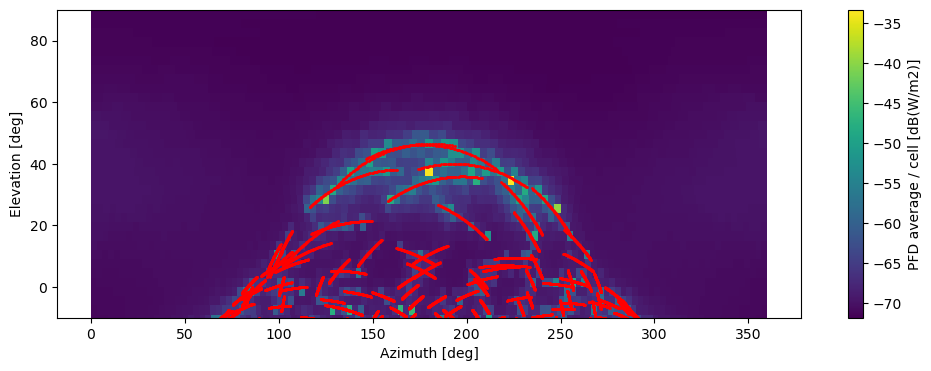

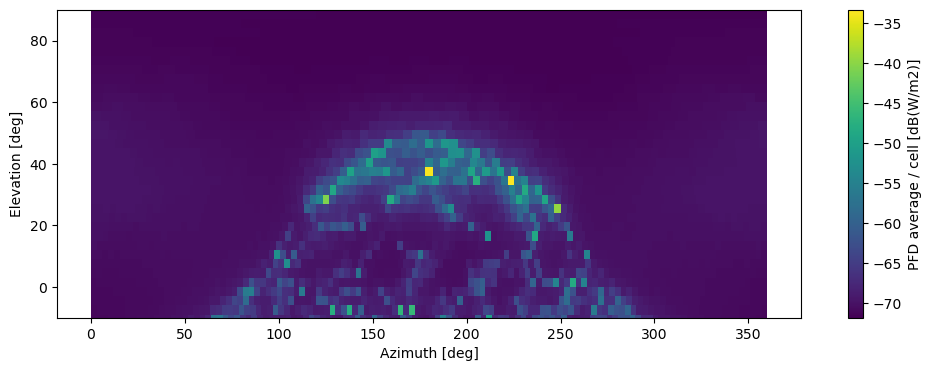

In [23]:


val = pfd_avg.to_value(cnv.dB_W_m2)
### plot with satellites
skynet.plotgrid(val,grid_info,point_az=test.topo_pos_az[telescopeindex,:,0,:,:,:],point_el=test.topo_pos_el[telescopeindex,:,0,:,:,:],
                elmax=90,elmin=-10)
### no satellites
skynet.plotgrid(val,grid_info,point_az=[],point_el=[],
                elmax=90,elmin=-10)